<a href="https://colab.research.google.com/github/ZilvinasKu/Data-Analysis/blob/main/Python_AB_chi2_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Install necessary libraries
!pip install --upgrade google-cloud-bigquery pandas matplotlib seaborn scipy

In [13]:
# Import libraries
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from IPython.display import display

In [14]:
# Authenticate the user
auth.authenticate_user()

# Initialize the BigQuery client
project_id = 'tc-da-1'
client = bigquery.Client(project=project_id)

In [15]:
# Query to fetch data from raw_events
query_events = """
SELECT campaign, user_pseudo_id
FROM `tc-da-1.turing_data_analytics.raw_events`
WHERE event_name = 'page_view'
AND (campaign LIKE '%NewYear%' OR campaign LIKE '%BlackFriday%' OR campaign LIKE '%Holiday%')
"""
df_events = client.query(query_events).to_dataframe()

# Process raw_events data to count unique users as estimated clicks
df_clicks = df_events.groupby('campaign').user_pseudo_id.nunique().reset_index()
df_clicks.columns = ['Campaign', 'EstimatedClicks']


In [16]:
# Query to fetch data from adsense_monthly
query_adsense = """
SELECT Month, Campaign, Impressions
FROM `tc-da-1.turing_data_analytics.adsense_monthly`
WHERE Campaign IN ('NewYear_V1', 'NewYear_V2', 'BlackFriday_V1', 'BlackFriday_V2', 'Holiday_V1', 'Holiday_V2')
"""
df_adsense = client.query(query_adsense).to_dataframe()


In [17]:
# Join the adsense data with the clicks data
df_merged = pd.merge(df_adsense, df_clicks, on='Campaign', how='inner')


In [18]:
# Calculate CTR (Click-Through Rate)
df_merged['CTR'] = (df_merged['EstimatedClicks'] / df_merged['Impressions']) * 100

In [19]:
# Display the merged data as a table
display(df_merged)


,Month,Campaign,Impressions,EstimatedClicks,CTR
0,202012,Holiday_V1,9585,16,0.166927
1,202112,Holiday_V2,11736,30,0.255624
2,202101,NewYear_V1,4430,57,1.286682
3,202101,NewYear_V2,13039,30,0.230079
4,202011,BlackFriday_V1,8220,8,0.097324
5,202111,BlackFriday_V1,6734,8,0.1188
6,202011,BlackFriday_V2,24276,24,0.098863


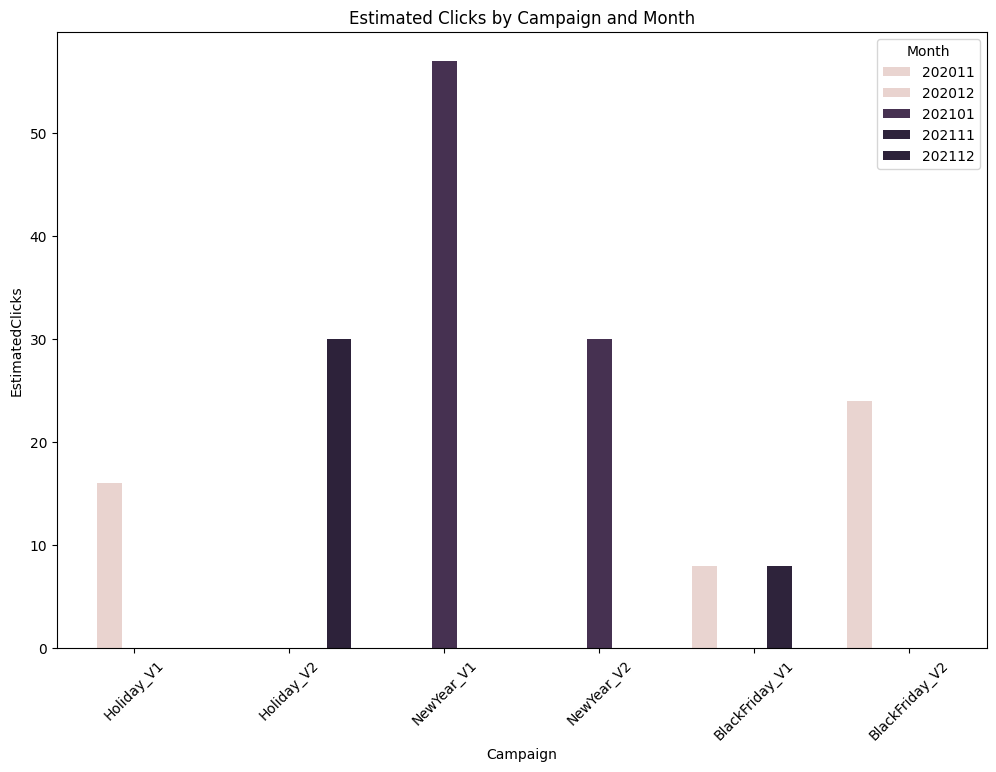

In [20]:
# Visualization: Bar plot for Estimated Clicks
plt.figure(figsize=(12, 8))
sns.barplot(x='Campaign', y='EstimatedClicks', hue='Month', data=df_merged)
plt.title('Estimated Clicks by Campaign and Month')
plt.xticks(rotation=45)
plt.show()


<ipython-input-21-00cd5c251c4a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Campaign', y='CTR', data=df_merged, palette='viridis')


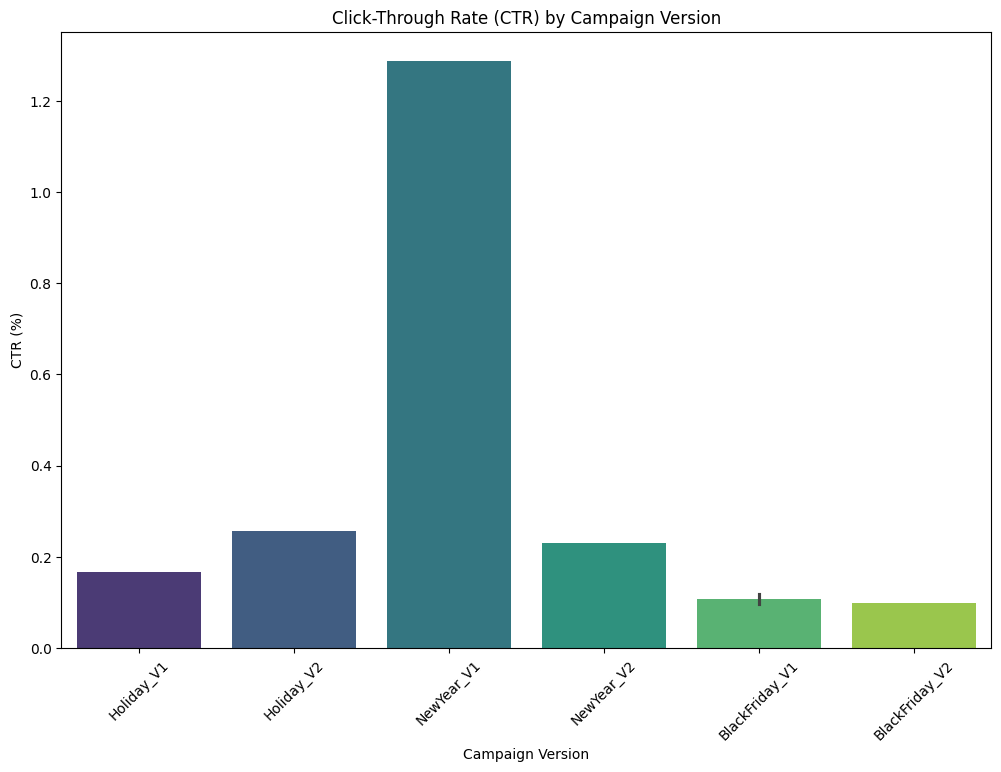

In [21]:
# Visualization: CTR for each campaign version
plt.figure(figsize=(12, 8))
sns.barplot(x='Campaign', y='CTR', data=df_merged, palette='viridis')
plt.title('Click-Through Rate (CTR) by Campaign Version')
plt.ylabel('CTR (%)')
plt.xlabel('Campaign Version')
plt.xticks(rotation=45)
plt.show()


In [22]:
# Perform A/B Testing for each campaign
campaigns = df_merged['Campaign'].str.extract(r'(\D+)_V\d')[0].unique()

# Chi-Square Test of Independence for Click Through Rate (CTR)
results = {}
for campaign in campaigns:
    subset = df_merged[df_merged['Campaign'].str.contains(campaign)]
    if subset['Campaign'].nunique() > 1:  # Ensure there are at least two versions to compare
        obs_clicks = subset['EstimatedClicks'].values
        obs_impressions = subset['Impressions'].values
        expected_clicks = obs_impressions * (obs_clicks.sum() / obs_impressions.sum())
        chi2, p = chi2_contingency(np.array([obs_clicks, expected_clicks]))[:2]
        results[campaign] = {'Chi2 Statistic': chi2, 'p-value': p}


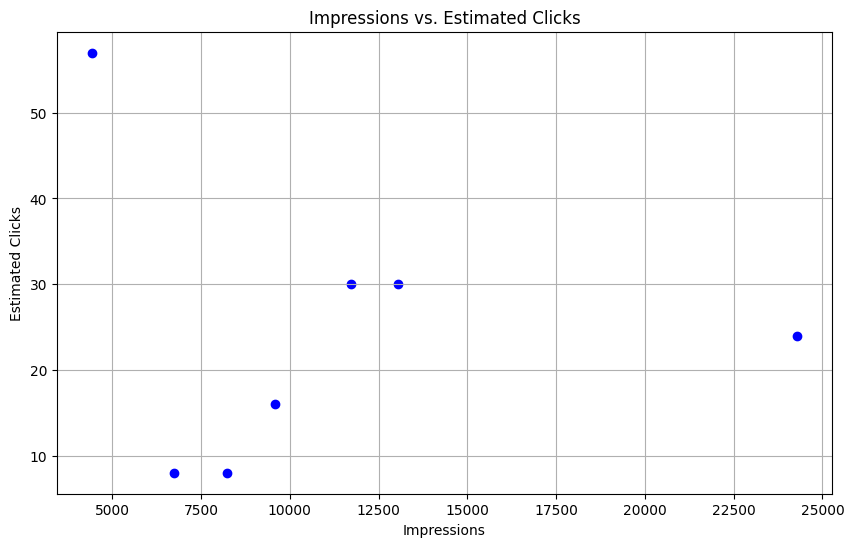

In [23]:
# Scatter plot for Impressions vs. EstimatedClicks
plt.figure(figsize=(10, 6))
plt.scatter(df_merged['Impressions'], df_merged['EstimatedClicks'], color='blue')
plt.title('Impressions vs. Estimated Clicks')
plt.xlabel('Impressions')
plt.ylabel('Estimated Clicks')
plt.grid(True)
plt.show()


In [24]:
# Display A/B test results
print("A/B Testing Results:")
for campaign, result in results.items():
    print(f"{campaign}: Chi2 Statistic = {result['Chi2 Statistic']}, p-value = {result['p-value']}")



A/B Testing Results:
Holiday: Chi2 Statistic = 0.6138776879909751, p-value = 0.43333151661129665
NewYear: Chi2 Statistic = 26.699327560551385, p-value = 2.3770422580799907e-07
BlackFriday: Chi2 Statistic = 0.10696732092478478, p-value = 0.9479214294751115
